In [2]:
import pandas as pd
import numpy as np
import keras
import keras.optimizers
from keras.datasets import mnist
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import Layer
from matplotlib import pyplot as plt
from tensorflow.keras.utils import to_categorical
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, Softmax
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.utils.np_utils import to_categorical
from keras.losses import Loss
from tensorflow.keras.optimizers import SGD, Adam,RMSprop, Adadelta
from random import randint
import tensorflow as tf


In [3]:
data = pd.read_csv("data.csv")

In [4]:
from sklearn.model_selection import train_test_split
X = data.drop(labels = ['Grade', 'Repeats'], axis = 1)
Y = data['Grade']
weights = data['Repeats']
#split dataset into train and test data


In [ ]:
weights = np.sqrt(weights)
weights = np.ceil(weights)
weights

In [7]:
grades = ['6B+', '7A', '7B', '7A+', '6C+', '7B+', '6C', '7C', '7C+','6B', '8A', '8B', '8A+', '8B+']
rep_arr = []
for i in range(len(grades)):
    rep_arr.append(i)

In [9]:
# Make Y numeric/categorical
Y.replace(grades, rep_arr, inplace = True)
Y

0        0
1        0
2        0
3        1
4        1
        ..
18162    0
18163    0
18164    0
18165    4
18166    7
Name: Grade, Length: 18167, dtype: int64

# Histogram of Route Grades

<AxesSubplot:>

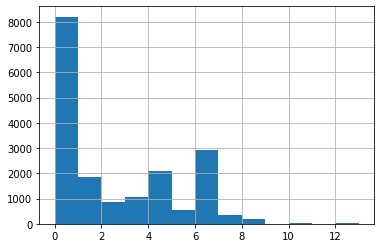

In [236]:
Y.hist(bins = len(grades) -1)

Notice This extreme right skew! We have way more routes that are graded as 6B's than any other difficulty! This means that our effective datapool for higher difficulties is going to be smaller. 


## Getting the rest of the data ready for models

In [11]:
# Convert X to numeric:

for col in X:
    X[col].replace(['N','U','S','F'], [0,1,1,1], inplace = True)
    

In [12]:
X

,1x0,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,18x1,18x2,18x3,18x4,18x5,18x6,18x7,18x8,18x9,18x10
0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18162,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
18163,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
18164,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
18165,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [13]:
X_train, X_test, Y_train, Y_test, w_train, w_test = train_test_split(X, Y, weights, test_size=0.2)

## Loss Function

I don't love the loss functions that tensorflow comes with on its own. So I'm going to create my own. 

In [69]:
class GradeLoss(Loss):

  def call(self, y_true, y_pred):
    y_pred = tf.cast(y_pred, tf.float32) # Some categorical number (we use one-hot encoding)
    y_true = tf.cast(y_true, tf.int64) # Another categorical
    cur_score = 0
    cur_score = tf.cast(cur_score, tf.float32)
    temp = 0
    div = tf.cast(len(y_pred), tf.float32)
    for t in range(len(y_pred)):
        temp1 = tf.math.argmax(y_pred[t])
        temp2 = tf.math.reduce_max(y_true[t])
        temp = tf.math.abs(tf.math.subtract(temp1, temp2))
        temp = tf.experimental.numpy.power(2, temp)
        temp = tf.cast(temp, tf.float32)
        temp = tf.math.reciprocal_no_nan(temp)
        cur_score = tf.math.add(cur_score, temp)
    return cur_score


In [68]:
def GradeMetric(y_true, y_pred):
    y_pred = tf.cast(y_pred, tf.float32) # Some categorical number (we use one-hot encoding)
    y_true = tf.cast(y_true, tf.int64) # Another categorical
    cur_acc = 0
    cur_acc = tf.cast(cur_acc, tf.float32)
    temp = 0
    div = tf.cast(len(y_pred), tf.float32)
    for t in range(len(y_pred)):
        temp1 = tf.math.argmax(y_pred[t])
        temp2 = tf.math.reduce_max(y_true[t])
        temp = tf.math.abs(tf.math.subtract(temp1, temp2))
        temp = tf.experimental.numpy.power(2, temp)
        temp = tf.cast(temp, tf.float32)
        temp = tf.math.reciprocal_no_nan(temp)
        cur_acc = tf.math.add(cur_acc, temp)
    return tf.math.divide(cur_acc, div)

In [108]:
def absGradeMetric(y_true, y_pred):
    close = 1
    y_pred = tf.cast(y_pred, tf.float32) # Some categorical number (we use one-hot encoding)
    y_true = tf.cast(y_true, tf.float32) # Another categorical
    cur_acc = 0
    cur_acc = tf.cast(cur_acc, tf.float32)
    temp = 0
    div = tf.cast(len(y_pred), tf.float32)
    for t in range(len(y_pred)):
        temp = tf.math.subtract(y_true[t], y_pred[t])
        temp = tf.math.abs(temp)
        temp = tf.math.less_equal(temp, [close])
        temp = tf.math.count_nonzero(temp)
        temp = tf.cast(temp, tf.float32)
        cur_acc = tf.math.add(cur_acc, temp)
    return tf.math.divide(cur_acc, div)

In [46]:
GradeMetric([[1]], [[0,0,1]])

tf.Tensor(2, shape=(), dtype=int64) tf.Tensor(1, shape=(), dtype=int64)


<tf.Tensor: shape=(), dtype=float32, numpy=0.5>

### Explanation for our functions. 

Our GradeMetric is the reciprocal of the difference of squares of the grades, plus one. We take this approach instead of a traditional "Categorized Correctly" approach since our categories are more like discrete numbers. There is a lot of similarity in real life between a 6B and a 6B+ (in fact, we would rank them the same in America). I may fiddle with the details more later, but giving a 0.5 for being off by one grade doesn't seem too inaccurate. From there, routes continue to get punished by a power of 2, so we would go to 0.25 for being off 2, 0.125 for being off 3, and so on. 

absGradeMetric is intended for models that treat grade as a continuous variable. It calculates the percentage of the time our estimates are within 1 of the true grade. 

## A Simple Start

In [92]:

epochs = 10
batch_size = 128
# lr - learning rate, momentum - additional parameter influencing gradient descent
optimizer = SGD(lr=0.001, momentum = 0.6) 
#optimizer = Adadelta()

inputs = keras.Input(shape=(198,)) # We give a 198 length vector

dense = Dense(250, activation="relu")
x = dense(inputs)
outputs = Dense(14)(x)
model = keras.Model(inputs=inputs, outputs=outputs, name="route_grader")
model.summary()
# Compile the model, asking also to keep track of accuracy at different iterations
model.compile(optimizer = optimizer, loss = 'SparseCategoricalCrossentropy', metrics = ['SparseCategoricalAccuracy'])



# Fit the model. If you want to see the progress, set verbose=True (it is also True by default)
history = model.fit(X_train, Y_train, epochs = epochs, verbose=True, shuffle=True,
                    validation_data = (X_test,Y_test), batch_size=batch_size)


Model: "route_grader"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 198)]             0         
                                                                 
 dense_56 (Dense)            (None, 250)               49750     
                                                                 
 dense_57 (Dense)            (None, 14)                3514      
                                                                 
Total params: 53,264
Trainable params: 53,264
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10


C:\Users\isaac\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


114/114 [==============================] - 1s 3ms/step - loss: 2.8707 - sparse_categorical_accuracy: 0.3987 - val_loss: 2.0767 - val_sparse_categorical_accuracy: 0.4463
Epoch 2/10
114/114 [==============================] - 0s 1ms/step - loss: 2.0777 - sparse_categorical_accuracy: 0.2408 - val_loss: 2.0643 - val_sparse_categorical_accuracy: 0.0927
Epoch 3/10
114/114 [==============================] - 0s 2ms/step - loss: 2.0315 - sparse_categorical_accuracy: 0.1357 - val_loss: 2.0068 - val_sparse_categorical_accuracy: 0.1535
Epoch 4/10
114/114 [==============================] - 0s 2ms/step - loss: 1.9459 - sparse_categorical_accuracy: 0.2102 - val_loss: 1.9446 - val_sparse_categorical_accuracy: 0.2328
Epoch 5/10
114/114 [==============================] - 0s 1ms/step - loss: 1.9058 - sparse_categorical_accuracy: 0.2851 - val_loss: 1.9298 - val_sparse_categorical_accuracy: 0.3110
Epoch 6/10
114/114 [==============================] - 0s 2ms/step - loss: 1.8806 - sparse_categorical_accuracy:

In [94]:
model.save("basic_model")

INFO:tensorflow:Assets written to: basic_model\assets


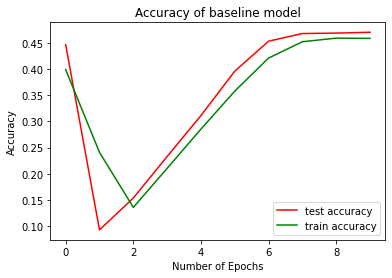

In [93]:
plt.plot(history.history['val_sparse_categorical_accuracy'], color='r', label="test accuracy")
plt.plot(history.history['sparse_categorical_accuracy'], color='g', label="train accuracy")

plt.title("Accuracy of baseline model")
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")

plt.legend()
plt.show()



Intrestingly, our model started off with a decent idea, lost that idea, but slowly discovered the correct way to classify with time. 

Ok, this "sparse_categorical_accuracy," misses the point a little. It assumes that the data are purely categorical, so this accuracy is the percentage of the time where our top guess is the correct grade. We spent a while making a new metric, how accurate is that one here?

In [95]:
model.compile(optimizer = optimizer, loss = GradeLoss(), metrics = [GradeMetric])
model.evaluate(X_test, Y_test)

114/114 [==============================] - 1s 2ms/step - loss: 17.4413 - GradeMetric: 0.5472


[17.44127655029297, 0.5471696853637695]

We have 54.5% accuracy here, which isn't partiucarly high or low. But it is about 10 percentage points higher than our previous accuracy, we would expect this because GradeMetric is more forgiving to errors of a few grades. This does indicate to some extent however, that our model is producing results that are close-ish to right-but theres a lot of room for improvement.

# Modifying the Model

## Sigmoid

In [98]:
epochs = 10
batch_size = 128
# lr - learning rate, momentum - additional parameter influencing gradient descent
optimizer = SGD(lr=0.001, momentum = 0.9) 
#optimizer = Adadelta()

sig_inputs = keras.Input(shape=(198,)) # We give a 198 length vector

dense = Dense(250, activation="sigmoid")
sig_x = dense(sig_inputs)
sig_outputs = Dense(14)(sig_x)
sig_model = keras.Model(inputs=sig_inputs, outputs=sig_outputs, name="route_grader")

# Compile the model, asking also to keep track of accuracy at different iterations
sig_model.compile(optimizer = optimizer, loss = 'SparseCategoricalCrossentropy', metrics = ['SparseCategoricalAccuracy'])



# Fit the model. If you want to see the progress, set verbose=True (it is also True by default)
sig_history = sig_model.fit(X_train, Y_train, epochs = epochs, verbose=True, shuffle=True,
                    validation_data = (X_test,Y_test), batch_size=batch_size)


Epoch 1/10


C:\Users\isaac\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


114/114 [==============================] - 1s 3ms/step - loss: 2.6827 - sparse_categorical_accuracy: 0.1064 - val_loss: 2.7631 - val_sparse_categorical_accuracy: 0.1230
Epoch 2/10
114/114 [==============================] - 0s 2ms/step - loss: 2.6366 - sparse_categorical_accuracy: 0.1210 - val_loss: 2.5588 - val_sparse_categorical_accuracy: 0.1244
Epoch 3/10
114/114 [==============================] - 0s 1ms/step - loss: 2.6227 - sparse_categorical_accuracy: 0.1228 - val_loss: 2.5476 - val_sparse_categorical_accuracy: 0.1255
Epoch 4/10
114/114 [==============================] - 0s 1ms/step - loss: 2.6400 - sparse_categorical_accuracy: 0.0973 - val_loss: 2.6501 - val_sparse_categorical_accuracy: 0.0198
Epoch 5/10
114/114 [==============================] - 0s 2ms/step - loss: 2.7109 - sparse_categorical_accuracy: 0.0202 - val_loss: 2.6459 - val_sparse_categorical_accuracy: 0.0198
Epoch 6/10
114/114 [==============================] - 0s 2ms/step - loss: 2.7085 - sparse_categorical_accuracy:

In [99]:
sig_model.save("sigmoid")

INFO:tensorflow:Assets written to: sigmoid\assets


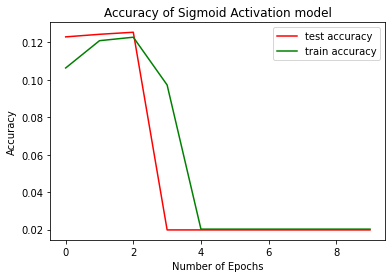

In [100]:
plt.plot(sig_history.history['val_sparse_categorical_accuracy'], color='r', label="test accuracy")
plt.plot(sig_history.history['sparse_categorical_accuracy'], color='g', label="train accuracy")

plt.title("Accuracy of Sigmoid Activation model")
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")

plt.legend()
plt.show()

The model using the sigmoid activators (even with tweaking it by adding different layers and different features), never really classifed routes correctly. It started out with an accuracy of about 12%, but that quickly fell with training. So it learned the wrong things here. 

# Continuous predictor?

What if we treat out outcome variable as a continuous value? So we just want to get as close to the true grade as possible?

In [187]:
epochs = 10
batch_size = 32
# lr - learning rate, momentum - additional parameter influencing gradient descent
coptimizer = SGD(lr=0.01, momentum = 0.9) 
#optimizer = Adadelta()

cinputs = keras.Input(shape=(198,)) # We give a 198 length vector
cx = dense(cinputs)
cx = Dense(250, activation="sigmoid")(cx)
#cx = Dense(100, activation="tanh")(cx)
coutputs = Dense(1)(cx)
c_model = keras.Model(inputs=cinputs, outputs=coutputs, name="route_grader")

# Compile the model, asking also to keep track of accuracy at different iterations
c_model.compile(optimizer = coptimizer, loss = 'mse', metrics = [absGradeMetric])



# Fit the model. If you want to see the progress, set verbose=True (it is also True by default)
c_history = c_model.fit(X_train, Y_train, epochs = epochs, verbose=True, shuffle=True,
                    validation_data = (X_test,Y_test), batch_size=batch_size)


Epoch 1/10


C:\Users\isaac\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


455/455 [==============================] - 2s 3ms/step - loss: 5.3916 - absGradeMetric: 0.2678 - val_loss: 5.5262 - val_absGradeMetric: 0.3827
Epoch 2/10
455/455 [==============================] - 1s 2ms/step - loss: 5.1182 - absGradeMetric: 0.2646 - val_loss: 5.3124 - val_absGradeMetric: 0.2055
Epoch 3/10
455/455 [==============================] - 1s 2ms/step - loss: 4.9962 - absGradeMetric: 0.2832 - val_loss: 5.0212 - val_absGradeMetric: 0.2792
Epoch 4/10
455/455 [==============================] - 1s 2ms/step - loss: 4.9552 - absGradeMetric: 0.2983 - val_loss: 4.9590 - val_absGradeMetric: 0.2848
Epoch 5/10
455/455 [==============================] - 1s 2ms/step - loss: 4.9333 - absGradeMetric: 0.3118 - val_loss: 5.3529 - val_absGradeMetric: 0.2290
Epoch 6/10
455/455 [==============================] - 1s 2ms/step - loss: 4.9202 - absGradeMetric: 0.3138 - val_loss: 4.9739 - val_absGradeMetric: 0.3060
Epoch 7/10
455/455 [==============================] - 1s 2ms/step - loss: 4.9418 - absG

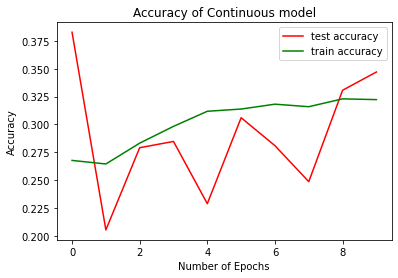

In [188]:
plt.plot(c_history.history['val_absGradeMetric'], color='r', label="test accuracy")
plt.plot(c_history.history['absGradeMetric'], color='g', label="train accuracy")

plt.title("Accuracy of Continuous model")
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")

plt.legend()
plt.show()

In [183]:
c_model.compile(optimizer = coptimizer, loss = 'mse', metrics = [absGradeMetric])
c = c_model.evaluate(X_test, Y_test)

114/114 [==============================] - 0s 2ms/step - loss: 4.9792 - absGradeMetric: 0.3282


This continuous model is all over the place. No matter the activations I try, or different number and sizes of layers, this model never really produces something of note. I've tested every single (appropriate) layer in the keras package, and none of them made this model insightful. 

# Adding in a Softmax (binary classification) layer:


In [153]:
epochs = 500
batch_size = 128
# lr - learning rate, momentum - additional parameter influencing gradient descent
optimizer = SGD(lr=0.0001, momentum = 0.9) 
#optimizer = Adadelta()

sinputs = keras.Input(shape=(198,)) # We give a 198 length vector

sdense = Dense(250, activation="relu")
sx = dense(sinputs)
sx = Dense(200, activation="elu")(sx)
sx = Dense(14, activation="elu")(sx)
soutputs = Softmax()(sx)
s_model = keras.Model(inputs=sinputs, outputs=soutputs, name="route_grader")

# Compile the model, asking also to keep track of accuracy at different iterations
s_model.compile(optimizer = optimizer, loss = 'SparseCategoricalCrossentropy', metrics = [tf.keras.metrics.SparseTopKCategoricalAccuracy(k=2)])



# Fit the model. If you want to see the progress, set verbose=True (it is also True by default)
s_history = s_model.fit(X_train, Y_train, epochs = epochs, verbose=False, shuffle=True,
                    validation_data = (X_test,Y_test), batch_size=batch_size)

C:\Users\isaac\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [154]:
s_history.history

{'loss': [1.9997131824493408,
  1.7705613374710083,
  1.7287288904190063,
  1.7069498300552368,
  1.6907767057418823,
  1.6771423816680908,
  1.6650079488754272,
  1.653590202331543,
  1.6430060863494873,
  1.632570743560791,
  1.6227302551269531,
  1.6128311157226562,
  1.6028892993927002,
  1.59283447265625,
  1.5826845169067383,
  1.573309302330017,
  1.5652016401290894,
  1.5577553510665894,
  1.5509943962097168,
  1.5447319746017456,
  1.53885018825531,
  1.5332984924316406,
  1.527966022491455,
  1.5229787826538086,
  1.5182710886001587,
  1.513617753982544,
  1.509297251701355,
  1.5050890445709229,
  1.5011863708496094,
  1.4973901510238647,
  1.4936714172363281,
  1.490114450454712,
  1.4867351055145264,
  1.483500599861145,
  1.4803218841552734,
  1.4772158861160278,
  1.474247694015503,
  1.4714775085449219,
  1.468629002571106,
  1.4659377336502075,
  1.463293433189392,
  1.4606571197509766,
  1.4581782817840576,
  1.455758810043335,
  1.453291654586792,
  1.451000213623046

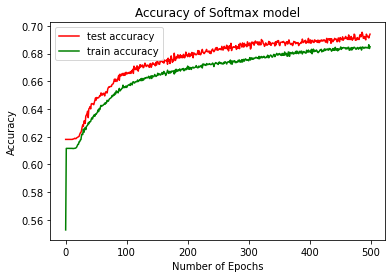

In [155]:
plt.plot(s_history.history['val_sparse_top_k_categorical_accuracy'], color='r', label="test accuracy")
plt.plot(s_history.history['sparse_top_k_categorical_accuracy'], color='g', label="train accuracy")

plt.title("Accuracy of Softmax model")
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")

plt.legend()
plt.show()

Our model gets to around 60% accuracy very quickly (as measured under a Top K metric, so if any of our top K guesses is correct, then we classify that as accurate).

I noticed that it got slightly better with time in my testing, so I decided to do one really big test to see if got more and more accurate, and that did seem to be the case. This model really could dial in to the data, ending up with an accuracy of around 69%

## K = 1

In [156]:
s_model.compile(optimizer = optimizer, loss = 'SparseCategoricalCrossentropy', metrics = [tf.keras.metrics.SparseTopKCategoricalAccuracy(k=1)])
s_model.evaluate(X_test,Y_test, batch_size = len(X_test))

1/1 [==============================] - 0s 108ms/step - loss: 1.2860 - sparse_top_k_categorical_accuracy: 0.5096


[1.2860229015350342, 0.5096312761306763]

## K = 2

In [157]:
s_model.compile(optimizer = optimizer, loss = 'SparseCategoricalCrossentropy', metrics = [tf.keras.metrics.SparseTopKCategoricalAccuracy(k=2)])
s_model.evaluate(X_test,Y_test, batch_size = len(X_test))

1/1 [==============================] - 0s 113ms/step - loss: 1.2860 - sparse_top_k_categorical_accuracy: 0.6940


[1.2860229015350342, 0.6940010786056519]

## K = 3

In [158]:
s_model.compile(optimizer = optimizer, loss = 'SparseCategoricalCrossentropy', metrics = [tf.keras.metrics.SparseTopKCategoricalAccuracy(k=3)])
s_model.evaluate(X_test,Y_test, batch_size = len(X_test))

1/1 [==============================] - 0s 110ms/step - loss: 1.2860 - sparse_top_k_categorical_accuracy: 0.8206


[1.2860229015350342, 0.8205834031105042]

So our model will find the true grade of climbing routes within the top 3 guesses 82.1% of the time! And within the top two 69.4% of the time!

## Running our "good" model with 3000 epochs. 

This model seemed particularly promising. And it really does seem to slowly learn the proper values over time. I have a decent computer, so I figured I should let it run. 

In [160]:
epochs = 3000
batch_size = 128
# lr - learning rate, momentum - additional parameter influencing gradient descent
optimizer = SGD(lr=0.0001, momentum = 0.9) 
#optimizer = Adadelta()

sinputs2 = keras.Input(shape=(198,)) # We give a 198 length vector

sdense2 = Dense(250, activation="relu")
sx2 = sdense2(sinputs2)
sx2 = Dense(200, activation="elu")(sx2)
sx2 = Dense(14, activation="elu")(sx2)
soutputs2 = Softmax()(sx2)
s2_model = keras.Model(inputs=sinputs2, outputs=soutputs2, name="route_grader")

# Compile the model, asking also to keep track of accuracy at different iterations
s2_model.compile(optimizer = optimizer, loss = 'SparseCategoricalCrossentropy', metrics = [tf.keras.metrics.SparseTopKCategoricalAccuracy(k=2)])



# Fit the model. If you want to see the progress, set verbose=True (it is also True by default)
s2_history = s2_model.fit(X_train, Y_train, epochs = epochs, verbose=False, shuffle=True,
                    validation_data = (X_test,Y_test), batch_size=batch_size)

C:\Users\isaac\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


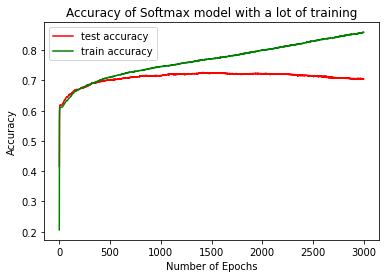

In [161]:
plt.plot(s2_history.history['val_sparse_top_k_categorical_accuracy'], color='r', label="test accuracy")
plt.plot(s2_history.history['sparse_top_k_categorical_accuracy'], color='g', label="train accuracy")

plt.title("Accuracy of Softmax model with a lot of training")
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")

plt.legend()
plt.show()

Ahah! This is not very insightful, but it shows that our model begins to overfit just after 500 or so Epochs. Not sure if it was worth the time it took to make, but it is too late now

# Making The Grade

The 6A-8C scale is a little wide for my tastes. Let's try condensing the grades, and retesting our initial models to see if that helps. We'll go from 14 classes to either 9 or 10. By collapsing our data a little bit, we should be able to grade routes with slightly higher accuracy.

In [162]:
grades

['6B+',
 '7A',
 '7B',
 '7A+',
 '6C+',
 '7B+',
 '6C',
 '7C',
 '7C+',
 '6B',
 '8A',
 '8B',
 '8A+',
 '8B+']

In [163]:
for i in range(len(rep_arr)):
    print(rep_arr[i], grades[i])

0 6B+
1 7A
2 7B
3 7A+
4 6C+
5 7B+
6 6C
7 7C
8 7C+
9 6B
10 8A
11 8B
12 8A+
13 8B+


In [164]:
alt_data = data.copy()
U = data.drop(labels = ['Grade', 'Repeats'], axis = 1)
V = data['Grade']

In [166]:
for col in U:
    U[col].replace(['N','U','S','F'], [0,1,1,1], inplace = True)
    

In [165]:
V.replace(grades, [0,0,1,1,2,3,4,4,5,6,7,8,9,10], inplace = True)


In [167]:
U_train, U_test, V_train, V_test = train_test_split(U, V, test_size=0.2)

In [226]:
epochs = 500
batch_size = 128
# lr - learning rate, momentum - additional parameter influencing gradient descent
optimizer = SGD(lr=0.0001, momentum = 0.9) 
#optimizer = Adadelta()

gsinputs = keras.Input(shape=(198,)) # We give a 198 length vector

gsdense = Dense(250, activation="relu")
gsx = dense(gsinputs)
gsx = Dense(200, activation="elu")(gsx)
gsx = Dense(14, activation="elu")(gsx)
gsoutputs = Softmax()(gsx)
gs_model = keras.Model(inputs=gsinputs, outputs=gsoutputs, name="route_grader")

# Compile the model, asking also to keep track of accuracy at different iterations
gs_model.compile(optimizer = optimizer, loss = 'SparseCategoricalCrossentropy', metrics = [tf.keras.metrics.SparseTopKCategoricalAccuracy(k=2)])



# Fit the model. If you want to see the progress, set verbose=True (it is also True by default)
gs_history = gs_model.fit(U_train, V_train, epochs = epochs, verbose=True, shuffle=True,
                    validation_data = (U_test,V_test), batch_size=batch_size)

Epoch 1/500


C:\Users\isaac\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


114/114 [==============================] - 1s 3ms/step - loss: 2.4490 - sparse_top_k_categorical_accuracy: 0.3369 - val_loss: 1.9812 - val_sparse_top_k_categorical_accuracy: 0.6073
Epoch 2/500
114/114 [==============================] - 0s 2ms/step - loss: 1.8712 - sparse_top_k_categorical_accuracy: 0.6143 - val_loss: 1.8136 - val_sparse_top_k_categorical_accuracy: 0.6073
Epoch 3/500
114/114 [==============================] - 0s 2ms/step - loss: 1.7657 - sparse_top_k_categorical_accuracy: 0.6143 - val_loss: 1.7428 - val_sparse_top_k_categorical_accuracy: 0.6079
Epoch 4/500
114/114 [==============================] - 0s 2ms/step - loss: 1.7096 - sparse_top_k_categorical_accuracy: 0.6142 - val_loss: 1.6980 - val_sparse_top_k_categorical_accuracy: 0.6084
Epoch 5/500
114/114 [==============================] - 0s 2ms/step - loss: 1.6713 - sparse_top_k_categorical_accuracy: 0.6139 - val_loss: 1.6651 - val_sparse_top_k_categorical_accuracy: 0.6087
Epoch 6/500
114/114 [==========================

114/114 [==============================] - 0s 2ms/step - loss: 1.3855 - sparse_top_k_categorical_accuracy: 0.6540 - val_loss: 1.4043 - val_sparse_top_k_categorical_accuracy: 0.6359
Epoch 44/500
114/114 [==============================] - 0s 2ms/step - loss: 1.3837 - sparse_top_k_categorical_accuracy: 0.6536 - val_loss: 1.4026 - val_sparse_top_k_categorical_accuracy: 0.6368
Epoch 45/500
114/114 [==============================] - 0s 2ms/step - loss: 1.3819 - sparse_top_k_categorical_accuracy: 0.6549 - val_loss: 1.4009 - val_sparse_top_k_categorical_accuracy: 0.6357
Epoch 46/500
114/114 [==============================] - 0s 2ms/step - loss: 1.3802 - sparse_top_k_categorical_accuracy: 0.6554 - val_loss: 1.3993 - val_sparse_top_k_categorical_accuracy: 0.6368
Epoch 47/500
114/114 [==============================] - 0s 2ms/step - loss: 1.3785 - sparse_top_k_categorical_accuracy: 0.6560 - val_loss: 1.3979 - val_sparse_top_k_categorical_accuracy: 0.6381
Epoch 48/500
114/114 [=====================

114/114 [==============================] - 0s 2ms/step - loss: 1.3412 - sparse_top_k_categorical_accuracy: 0.6701 - val_loss: 1.3639 - val_sparse_top_k_categorical_accuracy: 0.6508
Epoch 86/500
114/114 [==============================] - 0s 2ms/step - loss: 1.3406 - sparse_top_k_categorical_accuracy: 0.6707 - val_loss: 1.3634 - val_sparse_top_k_categorical_accuracy: 0.6489
Epoch 87/500
114/114 [==============================] - 0s 2ms/step - loss: 1.3400 - sparse_top_k_categorical_accuracy: 0.6708 - val_loss: 1.3631 - val_sparse_top_k_categorical_accuracy: 0.6508
Epoch 88/500
114/114 [==============================] - 0s 2ms/step - loss: 1.3394 - sparse_top_k_categorical_accuracy: 0.6704 - val_loss: 1.3624 - val_sparse_top_k_categorical_accuracy: 0.6508
Epoch 89/500
114/114 [==============================] - 0s 2ms/step - loss: 1.3389 - sparse_top_k_categorical_accuracy: 0.6705 - val_loss: 1.3619 - val_sparse_top_k_categorical_accuracy: 0.6508
Epoch 90/500
114/114 [=====================

114/114 [==============================] - 0s 2ms/step - loss: 1.3233 - sparse_top_k_categorical_accuracy: 0.6768 - val_loss: 1.3481 - val_sparse_top_k_categorical_accuracy: 0.6574
Epoch 128/500
114/114 [==============================] - 0s 2ms/step - loss: 1.3230 - sparse_top_k_categorical_accuracy: 0.6758 - val_loss: 1.3477 - val_sparse_top_k_categorical_accuracy: 0.6574
Epoch 129/500
114/114 [==============================] - 0s 2ms/step - loss: 1.3227 - sparse_top_k_categorical_accuracy: 0.6762 - val_loss: 1.3480 - val_sparse_top_k_categorical_accuracy: 0.6591
Epoch 130/500
114/114 [==============================] - 0s 2ms/step - loss: 1.3224 - sparse_top_k_categorical_accuracy: 0.6754 - val_loss: 1.3474 - val_sparse_top_k_categorical_accuracy: 0.6574
Epoch 131/500
114/114 [==============================] - 0s 2ms/step - loss: 1.3221 - sparse_top_k_categorical_accuracy: 0.6765 - val_loss: 1.3470 - val_sparse_top_k_categorical_accuracy: 0.6585
Epoch 132/500
114/114 [================

114/114 [==============================] - 0s 2ms/step - loss: 1.3131 - sparse_top_k_categorical_accuracy: 0.6798 - val_loss: 1.3397 - val_sparse_top_k_categorical_accuracy: 0.6626
Epoch 170/500
114/114 [==============================] - 0s 2ms/step - loss: 1.3129 - sparse_top_k_categorical_accuracy: 0.6796 - val_loss: 1.3396 - val_sparse_top_k_categorical_accuracy: 0.6624
Epoch 171/500
114/114 [==============================] - 0s 2ms/step - loss: 1.3127 - sparse_top_k_categorical_accuracy: 0.6796 - val_loss: 1.3392 - val_sparse_top_k_categorical_accuracy: 0.6637
Epoch 172/500
114/114 [==============================] - 0s 2ms/step - loss: 1.3124 - sparse_top_k_categorical_accuracy: 0.6800 - val_loss: 1.3393 - val_sparse_top_k_categorical_accuracy: 0.6632
Epoch 173/500
114/114 [==============================] - 0s 2ms/step - loss: 1.3125 - sparse_top_k_categorical_accuracy: 0.6796 - val_loss: 1.3388 - val_sparse_top_k_categorical_accuracy: 0.6624
Epoch 174/500
114/114 [================

114/114 [==============================] - 0s 2ms/step - loss: 1.3058 - sparse_top_k_categorical_accuracy: 0.6827 - val_loss: 1.3339 - val_sparse_top_k_categorical_accuracy: 0.6681
Epoch 212/500
114/114 [==============================] - 0s 2ms/step - loss: 1.3056 - sparse_top_k_categorical_accuracy: 0.6827 - val_loss: 1.3336 - val_sparse_top_k_categorical_accuracy: 0.6692
Epoch 213/500
114/114 [==============================] - 0s 2ms/step - loss: 1.3054 - sparse_top_k_categorical_accuracy: 0.6824 - val_loss: 1.3333 - val_sparse_top_k_categorical_accuracy: 0.6690
Epoch 214/500
114/114 [==============================] - 0s 2ms/step - loss: 1.3053 - sparse_top_k_categorical_accuracy: 0.6822 - val_loss: 1.3330 - val_sparse_top_k_categorical_accuracy: 0.6676
Epoch 215/500
114/114 [==============================] - 0s 2ms/step - loss: 1.3052 - sparse_top_k_categorical_accuracy: 0.6825 - val_loss: 1.3330 - val_sparse_top_k_categorical_accuracy: 0.6684
Epoch 216/500
114/114 [================

114/114 [==============================] - 0s 2ms/step - loss: 1.2998 - sparse_top_k_categorical_accuracy: 0.6843 - val_loss: 1.3291 - val_sparse_top_k_categorical_accuracy: 0.6714
Epoch 254/500
114/114 [==============================] - 0s 2ms/step - loss: 1.2997 - sparse_top_k_categorical_accuracy: 0.6850 - val_loss: 1.3290 - val_sparse_top_k_categorical_accuracy: 0.6712
Epoch 255/500
114/114 [==============================] - 0s 2ms/step - loss: 1.2996 - sparse_top_k_categorical_accuracy: 0.6849 - val_loss: 1.3289 - val_sparse_top_k_categorical_accuracy: 0.6701
Epoch 256/500
114/114 [==============================] - 0s 2ms/step - loss: 1.2995 - sparse_top_k_categorical_accuracy: 0.6843 - val_loss: 1.3290 - val_sparse_top_k_categorical_accuracy: 0.6709
Epoch 257/500
114/114 [==============================] - 0s 2ms/step - loss: 1.2994 - sparse_top_k_categorical_accuracy: 0.6846 - val_loss: 1.3285 - val_sparse_top_k_categorical_accuracy: 0.6725
Epoch 258/500
114/114 [================

114/114 [==============================] - 0s 2ms/step - loss: 1.2952 - sparse_top_k_categorical_accuracy: 0.6877 - val_loss: 1.3252 - val_sparse_top_k_categorical_accuracy: 0.6720
Epoch 296/500
114/114 [==============================] - 0s 2ms/step - loss: 1.2951 - sparse_top_k_categorical_accuracy: 0.6877 - val_loss: 1.3250 - val_sparse_top_k_categorical_accuracy: 0.6736
Epoch 297/500
114/114 [==============================] - 0s 2ms/step - loss: 1.2950 - sparse_top_k_categorical_accuracy: 0.6871 - val_loss: 1.3252 - val_sparse_top_k_categorical_accuracy: 0.6728
Epoch 298/500
114/114 [==============================] - 0s 2ms/step - loss: 1.2950 - sparse_top_k_categorical_accuracy: 0.6877 - val_loss: 1.3253 - val_sparse_top_k_categorical_accuracy: 0.6742
Epoch 299/500
114/114 [==============================] - 0s 2ms/step - loss: 1.2948 - sparse_top_k_categorical_accuracy: 0.6870 - val_loss: 1.3251 - val_sparse_top_k_categorical_accuracy: 0.6728
Epoch 300/500
114/114 [================

114/114 [==============================] - 0s 2ms/step - loss: 1.2913 - sparse_top_k_categorical_accuracy: 0.6893 - val_loss: 1.3221 - val_sparse_top_k_categorical_accuracy: 0.6728
Epoch 338/500
114/114 [==============================] - 0s 2ms/step - loss: 1.2913 - sparse_top_k_categorical_accuracy: 0.6895 - val_loss: 1.3222 - val_sparse_top_k_categorical_accuracy: 0.6736
Epoch 339/500
114/114 [==============================] - 0s 2ms/step - loss: 1.2912 - sparse_top_k_categorical_accuracy: 0.6888 - val_loss: 1.3222 - val_sparse_top_k_categorical_accuracy: 0.6736
Epoch 340/500
114/114 [==============================] - 0s 2ms/step - loss: 1.2911 - sparse_top_k_categorical_accuracy: 0.6891 - val_loss: 1.3220 - val_sparse_top_k_categorical_accuracy: 0.6734
Epoch 341/500
114/114 [==============================] - 0s 2ms/step - loss: 1.2909 - sparse_top_k_categorical_accuracy: 0.6889 - val_loss: 1.3224 - val_sparse_top_k_categorical_accuracy: 0.6742
Epoch 342/500
114/114 [================

114/114 [==============================] - 0s 2ms/step - loss: 1.2880 - sparse_top_k_categorical_accuracy: 0.6903 - val_loss: 1.3195 - val_sparse_top_k_categorical_accuracy: 0.6734
Epoch 380/500
114/114 [==============================] - 0s 2ms/step - loss: 1.2878 - sparse_top_k_categorical_accuracy: 0.6900 - val_loss: 1.3197 - val_sparse_top_k_categorical_accuracy: 0.6736
Epoch 381/500
114/114 [==============================] - 0s 2ms/step - loss: 1.2878 - sparse_top_k_categorical_accuracy: 0.6897 - val_loss: 1.3197 - val_sparse_top_k_categorical_accuracy: 0.6747
Epoch 382/500
114/114 [==============================] - 0s 2ms/step - loss: 1.2877 - sparse_top_k_categorical_accuracy: 0.6902 - val_loss: 1.3194 - val_sparse_top_k_categorical_accuracy: 0.6742
Epoch 383/500
114/114 [==============================] - 0s 2ms/step - loss: 1.2876 - sparse_top_k_categorical_accuracy: 0.6910 - val_loss: 1.3198 - val_sparse_top_k_categorical_accuracy: 0.6747
Epoch 384/500
114/114 [================

114/114 [==============================] - 0s 2ms/step - loss: 1.2849 - sparse_top_k_categorical_accuracy: 0.6913 - val_loss: 1.3172 - val_sparse_top_k_categorical_accuracy: 0.6764
Epoch 422/500
114/114 [==============================] - 0s 2ms/step - loss: 1.2848 - sparse_top_k_categorical_accuracy: 0.6926 - val_loss: 1.3172 - val_sparse_top_k_categorical_accuracy: 0.6767
Epoch 423/500
114/114 [==============================] - 0s 2ms/step - loss: 1.2847 - sparse_top_k_categorical_accuracy: 0.6914 - val_loss: 1.3173 - val_sparse_top_k_categorical_accuracy: 0.6761
Epoch 424/500
114/114 [==============================] - 0s 2ms/step - loss: 1.2847 - sparse_top_k_categorical_accuracy: 0.6912 - val_loss: 1.3171 - val_sparse_top_k_categorical_accuracy: 0.6772
Epoch 425/500
114/114 [==============================] - 0s 2ms/step - loss: 1.2846 - sparse_top_k_categorical_accuracy: 0.6916 - val_loss: 1.3172 - val_sparse_top_k_categorical_accuracy: 0.6767
Epoch 426/500
114/114 [================

114/114 [==============================] - 0s 2ms/step - loss: 1.2821 - sparse_top_k_categorical_accuracy: 0.6927 - val_loss: 1.3152 - val_sparse_top_k_categorical_accuracy: 0.6767
Epoch 464/500
114/114 [==============================] - 0s 2ms/step - loss: 1.2820 - sparse_top_k_categorical_accuracy: 0.6940 - val_loss: 1.3151 - val_sparse_top_k_categorical_accuracy: 0.6769
Epoch 465/500
114/114 [==============================] - 0s 2ms/step - loss: 1.2819 - sparse_top_k_categorical_accuracy: 0.6923 - val_loss: 1.3150 - val_sparse_top_k_categorical_accuracy: 0.6772
Epoch 466/500
114/114 [==============================] - 0s 2ms/step - loss: 1.2819 - sparse_top_k_categorical_accuracy: 0.6927 - val_loss: 1.3148 - val_sparse_top_k_categorical_accuracy: 0.6769
Epoch 467/500
114/114 [==============================] - 0s 2ms/step - loss: 1.2819 - sparse_top_k_categorical_accuracy: 0.6928 - val_loss: 1.3148 - val_sparse_top_k_categorical_accuracy: 0.6778
Epoch 468/500
114/114 [================

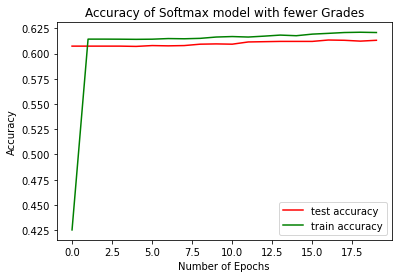

In [225]:
plt.plot(gs_history.history['val_sparse_top_k_categorical_accuracy'], color='r', label="test accuracy")
plt.plot(gs_history.history['sparse_top_k_categorical_accuracy'], color='g', label="train accuracy")

plt.title("Accuracy of Softmax model with fewer Grades")
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")

plt.legend()
plt.show()

In [ ]:
When we make our grades more compact, we don t

# Back to the Data

We know that no matter the model, if our data itself is bad, then the results of our model will be bad as well. If we are more restrictive on our routes, perhaps we can improve these models a bit. Before, we needed at least 4 or 5 uses to grade the routes before we accepted it. If we up our cutoff to 15 or more users, we still have a decent amount of data (around 7-8 thousand observations). 

In [199]:
red = pd.read_csv("data.csv")
red = red[red['Repeats'] > 14]

In [200]:
R = red.drop(labels = ['Grade', 'Repeats'], axis = 1)
T = red['Grade']

In [201]:
R = red.drop(labels = ['Grade', 'Repeats'], axis = 1)
T = red['Grade']

In [202]:
for col in R:
    R[col].replace(['N','U','S','F'], [0,1,1,1], inplace = True)
    

In [203]:
T.replace(grades, rep_arr, inplace = True)


In [214]:
R_train, R_test, T_train, T_test = train_test_split(R, T, test_size=0.2)

In [215]:
epochs = 20
batch_size = 32
# lr - learning rate, momentum - additional parameter influencing gradient descent
coptimizer = SGD(lr=0.01, momentum = 0.9) 
#optimizer = Adadelta()

cinputs = keras.Input(shape=(198,)) # We give a 198 length vector
cx = dense(cinputs)
cx = Dense(250, activation="sigmoid")(cx)
cx = Dense(100, activation="tanh")(cx)
coutputs = Dense(1)(cx)
c_model = keras.Model(inputs=cinputs, outputs=coutputs, name="route_grader")

# Compile the model, asking also to keep track of accuracy at different iterations
c_model.compile(optimizer = coptimizer, loss = 'mse', metrics = [absGradeMetric])



# Fit the model. If you want to see the progress, set verbose=True (it is also True by default)
c_history = c_model.fit(R_train, T_train, epochs = epochs, verbose=True, shuffle=True,
                    validation_data = (R_test,T_test), batch_size=batch_size)


Epoch 1/20


C:\Users\isaac\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


206/206 [==============================] - 1s 3ms/step - loss: 5.1736 - absGradeMetric: 0.3310 - val_loss: 4.8113 - val_absGradeMetric: 0.1925
Epoch 2/20
206/206 [==============================] - 0s 2ms/step - loss: 4.8528 - absGradeMetric: 0.3515 - val_loss: 4.7608 - val_absGradeMetric: 0.4195
Epoch 3/20
206/206 [==============================] - 0s 2ms/step - loss: 4.8112 - absGradeMetric: 0.3556 - val_loss: 4.8696 - val_absGradeMetric: 0.3165
Epoch 4/20
206/206 [==============================] - 0s 2ms/step - loss: 4.7042 - absGradeMetric: 0.3792 - val_loss: 5.0772 - val_absGradeMetric: 0.4906
Epoch 5/20
206/206 [==============================] - 0s 2ms/step - loss: 4.6503 - absGradeMetric: 0.3864 - val_loss: 4.5110 - val_absGradeMetric: 0.4327
Epoch 6/20
206/206 [==============================] - 0s 2ms/step - loss: 4.6209 - absGradeMetric: 0.3981 - val_loss: 4.6189 - val_absGradeMetric: 0.4189
Epoch 7/20
206/206 [==============================] - 0s 2ms/step - loss: 4.5436 - absG

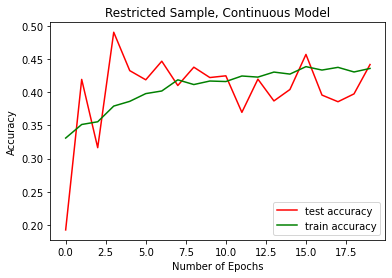

In [216]:
plt.plot(c_history.history['val_absGradeMetric'], color='r', label="test accuracy")
plt.plot(c_history.history['absGradeMetric'], color='g', label="train accuracy")

plt.title("Restricted Sample, Continuous Model")
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")

plt.legend()
plt.show()

In [219]:
epochs = 200
batch_size = 128
# lr - learning rate, momentum - additional parameter influencing gradient descent
optimizer = SGD(lr=0.0001, momentum = 0.9) 
#optimizer = Adadelta()

rsinputs = keras.Input(shape=(198,)) # We give a 198 length vector

rsdense = Dense(250, activation="relu")
rsx = dense(rsinputs)
rsx = Dense(200, activation="elu")(rsx)
rsx = Dense(14, activation="elu")(rsx)
rsoutputs = Softmax()(rsx)
rs_model = keras.Model(inputs=rsinputs, outputs=rsoutputs, name="route_grader")

# Compile the model, asking also to keep track of accuracy at different iterations
rs_model.compile(optimizer = optimizer, loss = 'SparseCategoricalCrossentropy', metrics = [tf.keras.metrics.SparseTopKCategoricalAccuracy(k=2)])



# Fit the model. If you want to see the progress, set verbose=True (it is also True by default)
rs_history = rs_model.fit(R_train, T_train, epochs = epochs, verbose=False, shuffle=True,
                    validation_data = (R_test,T_test), batch_size=batch_size)

C:\Users\isaac\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


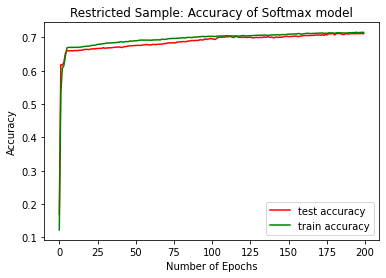

In [220]:
plt.plot(rs_history.history['val_sparse_top_k_categorical_accuracy'], color='r', label="test accuracy")
plt.plot(rs_history.history['sparse_top_k_categorical_accuracy'], color='g', label="train accuracy")

plt.title("Restricted Sample: Accuracy of Softmax model")
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")

plt.legend()
plt.show()

In [223]:
rs_model.compile(optimizer = optimizer, loss = 'SparseCategoricalCrossentropy', metrics = [tf.keras.metrics.SparseTopKCategoricalAccuracy(k=1)])
rs_model.evaluate(R_test, T_test)

52/52 [==============================] - 0s 885us/step - loss: 1.2071 - sparse_top_k_categorical_accuracy: 0.5310


[1.2070591449737549, 0.5310218930244446]

In [224]:
rs_model.compile(optimizer = optimizer, loss = 'SparseCategoricalCrossentropy', metrics = [GradeMetric])
rs_model.evaluate(R_test, T_test)

52/52 [==============================] - 0s 2ms/step - loss: 1.2071 - GradeMetric: 0.6018


[1.2070591449737549, 0.601802408695221]

I wanted to revist the continuous model, since when my sample size was smaller, that one was my best model, but it only does okay with our restricted sample. It is better than before though. Our Softmax model, similarly, does better than before, reaching over 70% accuracy with the Top K Accuracy metric. Using my GradeMetric, it only hits about 60% accuracy or so, which is  to be expected as my GradeMetric is similar to Top K with weights. When K = 1, our model accurately classifies routes correctly 53% of the time, which while low, our high scores with Grade Metric and Top K indicate that it usually guesses grades near each other (so if the true grade were an A, our model is guessing A- pretty frequently). 